# Tutorial 11 : Coupling a thermo-mechanical model with Badlands (2D)

This Tutorial requires pyBadlands.
You can run it using the docker images provided

![Tutorial11](images/Tutorial11.gif)

In [1]:
from underworld import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /home/jovyan/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# UW Model

In [4]:
Model = GEO.Model(elementRes=(192, 64), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="output_tutorialCoupling2D"

## Materials

In [7]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

The Model we are building is essentially a layered cake. The geodynamics module provide and easy way to define a layer by defining shape as *layer* and specifying its *top* and *bottom*. The order is important: when 2 shapes overlay each other, only the second is used.

In [8]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=2.0 * u.kilometer))
stickyAir = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=air.bottom, bottom= 0.0 * u.kilometer))
uppercrust = Model.add_material(name="UppperCrust", shape=GEO.shapes.Layer(top=stickyAir.bottom, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=uppercrust.bottom, bottom=-100.0 * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="Sediment")

In [9]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second

air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [10]:
air.density = 1. * u.kilogram / u.metre**3
stickyAir.density = 1. * u.kilogram / u.metre**3
uppercrust.density = GEO.LinearDensity(2620. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantleLithosphere.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantle.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
sediment.density = 2300. * u.kilogram / u.metre**3

In [11]:
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3
sediment.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

In [12]:
rh = GEO.ViscousCreepRegistry()

In [13]:
air.viscosity                = 1e19 * u.pascal * u.second
stickyAir.viscosity          = 1e20 * u.pascal * u.second
uppercrust.viscosity         = 5.0 * rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
mantleLithosphere.viscosity  = rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
mantle.viscosity             = 0.2 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
sediment.viscosity           = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

In [14]:
pl = GEO.PlasticityRegistry()

In [15]:
uppercrust.plasticity         = pl.Huismans_et_al_2011_Crust
mantleLithosphere.plasticity  = pl.Huismans_et_al_2011_Crust
mantle.plasticity             = pl.Huismans_et_al_2011_Crust
sediment.plasticity           = pl.Huismans_et_al_2011_Crust

In [16]:
sediment

## Boundary Conditions

In [17]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK)])

Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, None],
                       right=[2.5 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle, average=True))

## Initial Damage

In [18]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))


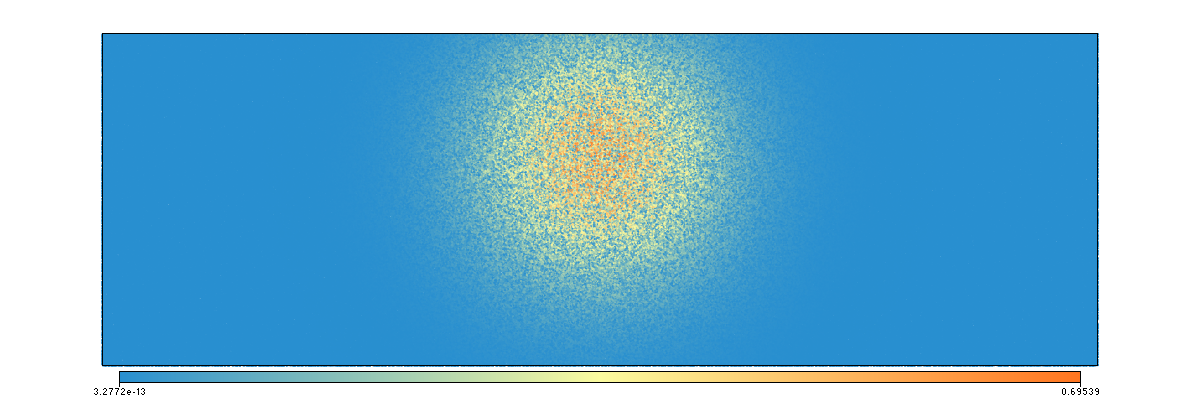

In [19]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.plasticStrain, fn_size=3.0)
Fig.show()


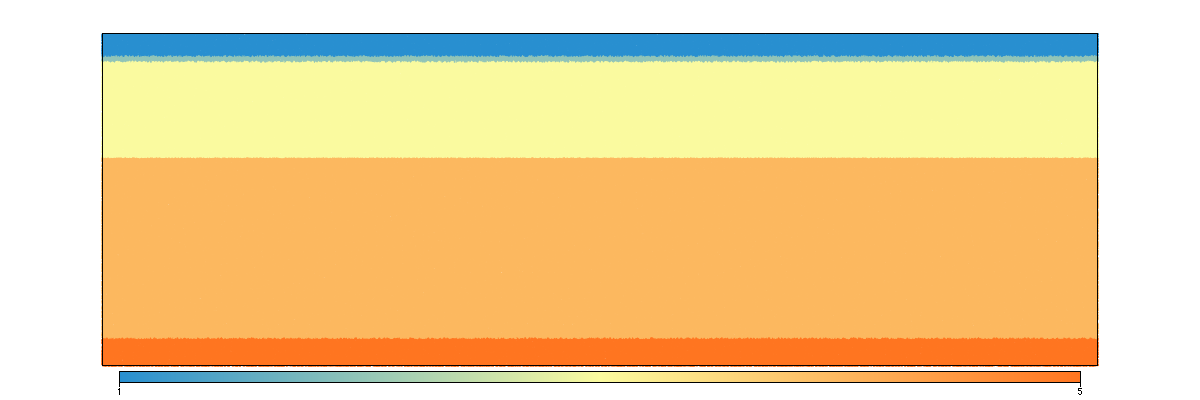

In [20]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()

In [21]:
Model.init_model(temperature="steady-state", pressure="lithostatic")


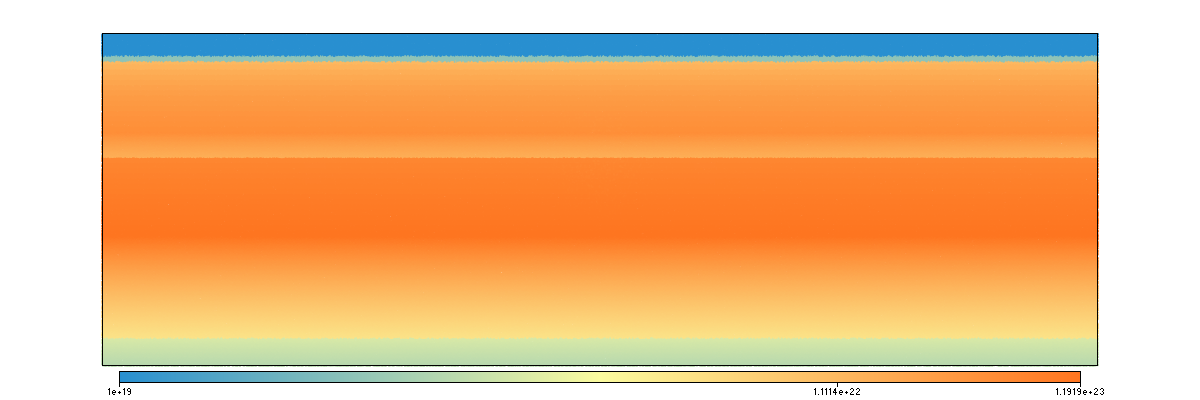

In [22]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal * u.second), fn_size=3.0, logScale=True)
Fig.show()

# Badlands

In [23]:
Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[stickyAir.index, air.index], sedimentIndex=sediment.index,
                                          XML="ressources/badlands.xml", resolution=1. * u.kilometer, 
                                          checkpoint_interval=0.01 * u.megayears)

## Run Model

In [25]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [ ]:
Model.run_for(nstep=2)

Running with UWGeodynamics version 0.9.9b-dev-bccb2f7(master)
Processing surface with Badlands
   - Writing outputs (0.65 seconds; tNow = 0.0)
tNow = 10000.0 (0.15 seconds)
   - Writing outputs (0.50 seconds; tNow = 10000.0)
Processing surface with Badlands...Done
Step:     1 Model Time: 0.01 megayear dt: 0.01 megayear (2018-12-05 21:05:17)
Processing surface with Badlands
tNow = 20000.0 (0.14 seconds)
   - Writing outputs (0.69 seconds; tNow = 20000.0)
Processing surface with Badlands...Done
Step:     2 Model Time: 0.02 megayear dt: 0.01 megayear (2018-12-05 21:05:50)
Processing surface with Badlands
tNow = 30000.0 (0.15 seconds)
   - Writing outputs (0.70 seconds; tNow = 30000.0)
Processing surface with Badlands...Done
Step:     3 Model Time: 0.03 megayear dt: 0.01 megayear (2018-12-05 21:06:26)
Processing surface with Badlands
tNow = 40000.0 (0.14 seconds)
   - Writing outputs (0.69 seconds; tNow = 40000.0)
Processing surface with Badlands...Done
Step:     4 Model Time: 0.04 megayea